# 作业三：选择模型并完成训练

## 评分标准

* 选择模型，可用套件，也可以自己组网 （30分）

* 配置超参数并训练模型（30分）

* 测试模型效果（30分）

* 可视化模型效果（10分）

## 数据处理

数据集准备，定义数据集类，加载数据集

In [1]:
# 使用gzip命令解压数据集文件
!gzip -dfq data/data65/t10k-labels-idx1-ubyte.gz
!gzip -dfq data/data65/train-labels-idx1-ubyte.gz
!gzip -dfq data/data65/t10k-images-idx3-ubyte.gz
!gzip -dfq data/data65/train-images-idx3-ubyte.gz

In [2]:
# 定义数据集类
import paddle
import numpy as np
import struct

class MyMNISTDataset(paddle.io.Dataset):
    def __init__(self, image_file, label_file):
        super(MyMNISTDataset, self).__init__()
        self.images = self.decode_idx3_ubyte(image_file)
        self.labels = self.decode_idx1_ubyte(label_file)
        self.length = len(self.labels)

    def __getitem__(self, index):
        return self.images[index].astype('float32'), self.labels[index].astype('int64')

    def __len__(self):
        return self.length

    def decode_idx3_ubyte(self, idx3_ubyte_file):
        bin_data = open(idx3_ubyte_file, 'rb').read()
        offset = 0
        fmt_header = '>iiii'
        magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
        image_size = num_rows * num_cols
        offset += struct.calcsize(fmt_header)
        fmt_image = '>' + str(image_size) + 'B'
        images = np.empty((num_images, num_rows, num_cols), dtype=np.uint8)
        for i in range(num_images):
            images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
            offset += struct.calcsize(fmt_image)
        images = np.expand_dims(images, axis=1)
        return images

    def decode_idx1_ubyte(self,idx1_ubyte_file):
        bin_data = open(idx1_ubyte_file, 'rb').read()
        offset = 0
        fmt_header = '>ii'
        magic_number, num_labels = struct.unpack_from(fmt_header, bin_data, offset)
        offset += struct.calcsize(fmt_header)
        fmt_label = '>B'
        labels = np.empty(num_labels, dtype=np.uint8)
        for i in range(num_labels):
            labels[i] = struct.unpack_from(fmt_label, bin_data, offset)[0]
            offset += struct.calcsize(fmt_label)
        labels = np.expand_dims(labels, axis=-1)
        return labels

In [3]:
# 加载数据集
train_dataset = MyMNISTDataset("data/data65/train-images-idx3-ubyte", "data/data65/train-labels-idx1-ubyte")
test_dataset = MyMNISTDataset("data/data65/t10k-images-idx3-ubyte", "data/data65/t10k-labels-idx1-ubyte")

## 模型准备

（为了缩短开发周期，建议选择飞桨官方套件，如果有余力可以自己组网实现）

In [4]:
# 模型准备，初期采用Lenet模型

import paddle.nn as nn
import paddle.nn.functional as F

class Lenet(nn.Layer):
    def __init__(self):
        super(Lenet, self).__init__()
        self.conv1 = nn.Conv2D(1, 6, 5)
        self.pool1 = nn.MaxPool2D(2, 2)
        self.conv2 = nn.Conv2D(6, 16, 5)
        self.pool2 = nn.MaxPool2D(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = paddle.flatten(x, start_axis=1, stop_axis=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.softmax(self.fc3(x))
        return x

## 模型训练

训练模型需要说明：

* lr_schedule
* optimize
* epoch
* batch_size
* Loss function

In [5]:
# 定义模型参数
from paddle.optimizer import Adam

lr = 0.001

model = paddle.Model(Lenet())
opt = Adam(learning_rate=lr, parameters=model.parameters())

epoch = 10

batch_size = 64

loss = nn.CrossEntropyLoss()

model.prepare(
    optimizer=opt,
    loss=loss,
    metrics=paddle.metric.Accuracy())

W0227 05:50:14.961468   252 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0227 05:50:14.965730   252 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [6]:
# 模型训练
model.fit(train_dataset,
          epochs=epoch,
          batch_size=batch_size,
          save_dir='my_mnist_model',
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step  40/938 [>.............................] - loss: 11.7883 - acc: 0.2969 - ETA: 12s - 14ms/st

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step  90/938 [=>............................] - loss: 2.9223 - acc: 0.4613 - ETA: 7s - 9ms/stepstep 938/938 [==============================] - loss: 0.1076 - acc: 0.8248 - 4ms/step        
save checkpoint at /home/aistudio/my_mnist_model/0
Epoch 2/10
step 938/938 [==============================] - loss: 0.2668 - acc: 0.9363 - 4ms/step         
save checkpoint at /home/aistudio/my_mnist_model/1
Epoch 3/10
step 938/938 [==============================] - loss: 0.0033 - acc: 0.9567 - 4ms/step        
save checkpoint at /home/aistudio/my_mnist_model/2
Epoch 4/10
step 938/938 [==============================] - loss: 0.0106 - acc: 0.9684 - 4ms/step         
save checkpoint at /home/aistudio/my_mnist_model/3
Epoch 5/10
step 938/938 [==============================] - loss: 0.1063 - acc: 0.9733 - 4ms/step         
save checkpoint at /home/aistudio/my_mnist_model/4
Epoch 6/10
step 938/938 [==============================] - loss: 0.3244 - acc: 0.9776 - 4ms/step         
save checkpoint at /home/ai

## 测试模型

如果可以可视化模型效果则加分

Predict begin...
step 10000/10000 [==============================] - 1ms/step        
Predict samples: 10000
测试集第1个样本标签为:  7 	 预测值为： 7
测试集第2个样本标签为:  2 	 预测值为： 2
测试集第3个样本标签为:  1 	 预测值为： 1
测试集第4个样本标签为:  0 	 预测值为： 0
测试集第5个样本标签为:  4 	 预测值为： 4
模型在测试集上准确率为：97.91%


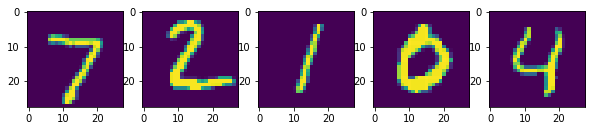

In [9]:
# 测试模型

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

preds = model.predict(test_dataset)[0]
preds = list(str(np.argmax(pred)) for pred in preds)
test_labels = list(str(data[1][0]) for data in test_dataset)

plt.figure(figsize=(10,2))
for i in range(5):
    print(f'测试集第{i + 1}个样本标签为: ', test_labels[i], '\t', '预测值为：', preds[i])
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_dataset[i][0].reshape([28,28]))

acc_score = accuracy_score(test_labels, preds)
print('模型在测试集上准确率为：%.2f%%' % (acc_score * 100))